# Hello World Tensorflow Regression

## Imports and init

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import tensorflow as tf

print("Tensorflow {}".format(tf.__version__))
EPOCHS = 750
n_samples=10
mean_samples=20.0
std_samples=5.0

Tensorflow 2.4.1


## Create some synthetic data

In [2]:
celsius = np.random.randn(n_samples)*std_samples+mean_samples
fahrenheit = celsius * 1.8 + 32
for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

14.037863051534657 degrees Celsius = 57.26815349276238 degrees Fahrenheit
18.118983420310272 degrees Celsius = 64.61417015655849 degrees Fahrenheit
25.583225337835422 degrees Celsius = 78.04980560810375 degrees Fahrenheit
33.30579567515749 degrees Celsius = 91.95043221528348 degrees Fahrenheit
23.637804185359474 degrees Celsius = 74.54804753364706 degrees Fahrenheit
19.94904042993423 degrees Celsius = 67.9082727738816 degrees Fahrenheit
17.62983583158176 degrees Celsius = 63.73370449684717 degrees Fahrenheit
17.62488858667135 degrees Celsius = 63.72479945600843 degrees Fahrenheit
12.725487487574448 degrees Celsius = 54.90587747763401 degrees Fahrenheit
18.90230783620124 degrees Celsius = 66.02415410516224 degrees Fahrenheit


This is what the data looks like

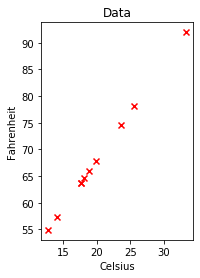

In [3]:
fig = plt.figure(1)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(celsius, fahrenheit, c='r', marker='x')
ax.set_xlabel("Celsius")
ax.set_ylabel("Fahrenheit")
ax.set_title("Data")
plt.show()

## Create a class to save the model parameters after every batch

In [4]:
class BatchLossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []
        self.batch_weights = []
        self.batch_biases = []

    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))
        self.batch_weights.append(self.model.layers[0].trainable_weights[0][0,0].numpy())
        self.batch_biases.append(self.model.layers[0].trainable_weights[1][0].numpy())


## Simple Model

### Create the model

In [5]:
l0 = tf.keras.layers.Dense(units=1, input_shape=[1])
model = tf.keras.Sequential([l0])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))
l0_weights_init = l0.get_weights()
print("Simple Model - layer variables init: {}".format(l0_weights_init))

Simple Model - layer variables init: [array([[-0.778194]], dtype=float32), array([0.], dtype=float32)]


### Train the model

In [6]:
batch_history_simple = BatchLossHistory()
history_simple = model.fit(celsius, fahrenheit, epochs=EPOCHS, callbacks=[batch_history_simple], verbose=False)
print("Finished training the simple model ")
l0_weights_end = l0.get_weights()
print("Simple Model - Layer variables end: {}".format(l0_weights_end))

Finished training the simple model 
Simple Model - Layer variables end: [array([[2.7278311]], dtype=float32), array([11.870553], dtype=float32)]


### Analyse the model results

In [7]:
c = [20.0]
f = model.predict(c)
print("Simple model predicts that 20 degrees Celsius is: {} degrees Fahrenheit".format(f))
f_gt = np.array(c) * 1.8 + 32
print("Simple model error is: {} degrees Fahrenheit".format(f-f_gt))

Simple model predicts that 20 degrees Celsius is: [[66.42718]] degrees Fahrenheit
Simple model error is: [[-1.57282257]] degrees Fahrenheit


### Analyse the model convergence

Text(0.5, 0.92, 'Simple Model')

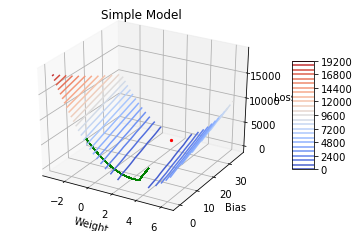

In [8]:
weight_history = batch_history_simple.batch_weights;
bias_history = batch_history_simple.batch_biases;
loss_history = batch_history_simple.batch_losses;

half_range = 5
weight = np.arange(1.8 - half_range, 1.8 + half_range, half_range/10.0)
bias = np.arange(32 - half_range - 28, 32 + half_range, half_range/10.0)
weight_grid_3D, bias_grid_3D, celsius_grid_3D = np.meshgrid(weight, bias, celsius)
squared_error = ((celsius_grid_3D * weight_grid_3D + bias_grid_3D) - (celsius_grid_3D * 1.8 + 32))**2
mean_squared_error = np.mean(squared_error, axis=2)
weight_grid_2D, bias_grid_2D = np.meshgrid(weight, bias)

fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, projection='3d')
# surf = ax.plot_surface(weight_grid_2D, bias_grid_2D, mean_squared_error, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# ax.set_zlim(0.0, 20000.0)
contour = ax.contour3D(weight_grid_2D, bias_grid_2D, mean_squared_error, 25, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(contour, shrink=0.5, aspect=5)
line = ax.plot(weight_history, bias_history, loss_history, 'g-', linewidth=1, antialiased=False)
scatter = ax.scatter([1.8], [32], [0], c='r', marker='.')
ax.set_xlabel("Weight")
ax.set_ylabel("Bias")
ax.set_zlabel("Loss")
ax.set_title("Simple Model")

## Complex Model

### Create the model

In [9]:
l0 = tf.keras.layers.Dense(units=4, input_shape=[1])
l1 = tf.keras.layers.Dense(units=4)
l2 = tf.keras.layers.Dense(units=1)
model = tf.keras.Sequential([l0, l1, l2])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1))

### Train the model

In [10]:
batch_history_complex = BatchLossHistory()
history_complex = model.fit(celsius, fahrenheit, epochs=EPOCHS, callbacks=[batch_history_complex], verbose=False)
print("Finished training the complex model")

Finished training the complex model


### Analyse model results

In [11]:
c = np.array([20.0], dtype=float)
f = model.predict(c)
print("Complex model predicts that 20 degrees Celsius is: {} degrees Fahrenheit".format(f))
f_gt = np.array(c) * 1.8 + 32
print("Complex model error is: {} degrees Fahrenheit".format(f-f_gt))

Complex model predicts that 20 degrees Celsius is: [[68.]] degrees Fahrenheit
Complex model error is: [[0.]] degrees Fahrenheit


### Analyse model parameters

In [12]:
print("Complex model layer variables")
print(" l0 variables: {}".format(l0.get_weights()))
print(" l1 variables: {}".format(l1.get_weights()))
print(" l2 variables: {}".format(l2.get_weights()))

Complex model layer variables
 l0 variables: [array([[-0.50868213,  0.33020502, -0.79297054, -0.34130454]],
      dtype=float32), array([-3.5329473 ,  0.60590017, -3.4987686 ,  2.780253  ], dtype=float32)]
 l1 variables: [array([[ 0.16484202,  1.3009845 ,  0.60097706, -0.30283606],
       [ 0.23859921, -0.14203936,  0.99023443, -1.0946248 ],
       [ 0.9903818 ,  0.88946253,  0.5878903 , -0.32850677],
       [-0.4623971 , -0.923365  , -0.17344637,  1.8420386 ]],
      dtype=float32), array([-2.3060122 , -3.2773032 , -1.060991  ,  0.61480045], dtype=float32)]
 l2 variables: [array([[-0.586882  ],
       [-1.4768656 ],
       [-0.21034831],
       [ 0.47820368]], dtype=float32), array([2.893966], dtype=float32)]


## Simple model with normalized data

### Define normalization/denormalization functions and normalize data

In [13]:
def normalize(values):
    values_std = np.std(values)
    values_mean = np.mean(values)
    values_n = (values-values_mean)/values_std
    return (values_n, values_mean, values_std)

def denormalize(values_n, values_mean, values_std):
    values_u = values_n*values_std+values_mean
    return values_u

celsius_n, celsius_mean, celsius_std  = normalize(celsius)
fahrenheit_n, fahrenheit_mean, fahrenheit_std  = normalize(fahrenheit)

### Create the model

In [14]:
l0_n = tf.keras.layers.Dense(units=1, input_shape=[1])
model_n = tf.keras.Sequential([l0_n])
model_n.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.1) )
l0_weights_n_init = l0_n.get_weights()
print("Normalized Model - layer variables init: {}".format(l0_weights_n_init))

Normalized Model - layer variables init: [array([[-0.4737885]], dtype=float32), array([0.], dtype=float32)]


### Train the model

In [15]:
batch_history_normalized = BatchLossHistory()
history_simple_normalized = model_n.fit(celsius_n, fahrenheit_n, epochs=EPOCHS, callbacks=[batch_history_normalized], verbose=False)
print("Finished training the simple model with normalized data")
l0_weights_n_end = l0_n.get_weights()
print("Normalized Model - Layer variables end: {}".format(l0_weights_n_end))

Finished training the simple model with normalized data
Normalized Model - Layer variables end: [array([[1.]], dtype=float32), array([-1.188462e-09], dtype=float32)]


### Analyse model results

In [16]:
c = [20.0]
f_gt = np.array(c) * 1.8 + 32
c=(c-celsius_mean)/celsius_std
f=model_n.predict(c)
f=denormalize(f, fahrenheit_mean, fahrenheit_std)
print("Normalized model predicts that 20 degrees Celsius is: {} degrees Fahrenheit".format(f))
print("Normalized model error is: {} degrees Fahrenheit".format(f-f_gt))

Normalized model predicts that 20 degrees Celsius is: [[68.]] degrees Fahrenheit
Normalized model error is: [[0.]] degrees Fahrenheit


### Visualise model convergence

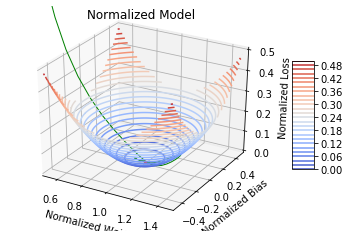

In [17]:
weight_history_n = batch_history_normalized.batch_weights;
bias_history_n = batch_history_normalized.batch_biases;
loss_history_n = batch_history_normalized.batch_losses;

weight_n = np.arange(1 - 0.5, 1 + 0.5, 0.01)
bias_n = np.arange(0 - 0.5, 0 + 0.5, 0.01)
weight_grid_3D_n, bias_grid_3D_n, celsius_grid_3D_n = np.meshgrid(weight_n, bias_n, celsius_n)

squared_error_n = ( (celsius_grid_3D_n * weight_grid_3D_n + bias_grid_3D_n) - ((denormalize(celsius_grid_3D_n, celsius_mean,  celsius_std ) * 1.8 + 32 - fahrenheit_mean)/fahrenheit_std) )**2
mean_squared_error_n = np.mean(squared_error_n, axis=2)
weight_grid_2D_n, bias_grid_2D_n = np.meshgrid(weight_n, bias_n)

fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim(0.5, 1.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0.0, 0.5)

contour = ax.contour3D(weight_grid_2D_n, bias_grid_2D_n, mean_squared_error_n, 25, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(contour, shrink=0.5, aspect=5)
line = ax.plot(weight_history_n, bias_history_n, loss_history_n, 'g-', linewidth=1)
# line = ax.scatter(weight_history_n, bias_history_n, loss_history_n, cmap=cm.coolwarm, linewidth=1)
scatter = ax.scatter([1], [0], [0], c='r', marker='.')
ax.set_xlabel("Normalized Weight")
ax.set_ylabel("Normalized Bias")
ax.set_zlabel("Normalized Loss")
ax.set_title("Normalized Model")

plt.show()

## Compare model convergences (loss vs epoch)

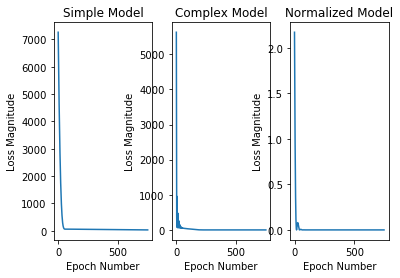

In [18]:
plt.figure(3)
plt.subplot(1,3,1)
plt.plot(history_simple.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.title("Simple Model")

plt.subplot(1,3,2)
plt.plot(history_complex.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.title("Complex Model")

plt.subplot(1,3,3)
plt.plot(history_simple_normalized.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.title("Normalized Model")
plt.show()